# Advances in Machine Learning with Big Data

### (part 1 of 2) 
### Trinity 2020 Weeks 1 - 4
### Dr Jeremy Large
#### jeremy.large@economics.ox.ac.uk


&#169; Jeremy Large ; shared under [CC BY-NC-ND 4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/)

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
plt.rcParams['figure.figsize'] = [15, 3]

import sys, os

import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

# point at library; I need some lessons on doing good PYTHONPATHs:
REPO_DIR = os.path.dirname(os.getcwd())
UCI_LIB = os.path.join(REPO_DIR, 'lib')
sys.path.append(UCI_LIB)

import numpy as np  
import pandas as pd  

#  pull in scikit-learn libraries:
from sklearn import linear_model
from sklearn import metrics

import sbs_sklearn    # module where I've put some functions from the last class
from uci_retail_data import uci_files, stock_codes

import itertools      # today, we'll use this

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_coeffs(mod, mod_name, comment):
    plt.plot(mod.coef_, marker='o')
    plt.grid()
    plt.title(f"The betas of the {mod_name} - {comment}")
    plt.axhline(color='k')

## 5. Resampling methods, and model selection

## Contents Weeks 1-4:

1. Introducing this course's dataset

1. Being an econometrician _and_ a data scientist

1. Overfit and regularization

1. Regularization through predictor/feature selection (Lasso etc.)

1. **Resampling methods, and model selection**

1. Decision trees, bagging, and random forests

1. Single-layer neural networks

Load data per previous classes ...

In [3]:
df = uci_files.standard_uci_data_access()

2020-04-26 14:26:42,633 INFO:Loading C:\Users\jerem\Documents\work\Oxford\SBS\MLBD\ox-sbs-ml-bd\data\raw.csv , sheet Year 2009-2010
2020-04-26 14:26:49,402 INFO:Loaded C:\Users\jerem\Documents\work\Oxford\SBS\MLBD\ox-sbs-ml-bd\data\raw.csv , sheet number one, obviously


In [4]:
invalids = stock_codes.invalid_series(df)

In [5]:
invoices = stock_codes.invoice_df(df, invalid_series=invalids)

Prepare our dataset for linear regression:

In [6]:
invoices['log_item_spend'] = np.log(invoices.invoice_spend / invoices.items_in_invoice)
invoices['log_n_codes'] = np.log(invoices.codes_in_invoice)

predictors = ['log_n_codes', 'hour', 'month', 'words_per_item']

y = invoices.log_item_spend
X = invoices[predictors] 

In [7]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(4)
polynomial_X = pd.DataFrame(poly.fit_transform(X.values))
polynomial_X.columns = poly.get_feature_names(X.columns)
del polynomial_X['1']

In [8]:
poly_std_X = ((polynomial_X - polynomial_X.mean()) / polynomial_X.std())

### We will try to tune [Elastic Net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) on this data.

#### First, recall class 4:

In [9]:
n_folds = 25

Here I hard-code my guesses at good parameters values for `alpha` and `l1_ratio`

In [10]:
elastic = linear_model.ElasticNet( # << Elastic Net here
                                  alpha=25 / (len(y) / n_folds) / 2,   # alpha parameter
                                  l1_ratio=0.33                        # how to distribute the parameter between l1 and l2 norms
                                 )

Do the hard work:

In [11]:
scores = sbs_sklearn.train_n_test(poly_std_X, y, n_folds, train_on_minority=True, model=elastic)

2020-04-26 14:27:21,078 INFO:Study 1/25: 824 train rows;  19753 test rows


Plot the results

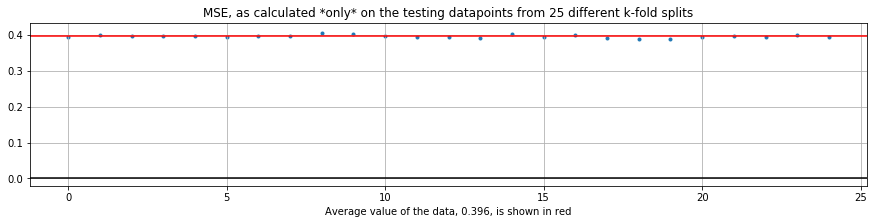

In [12]:
sbs_sklearn.plot_kfold_scores(scores, scatter=True)

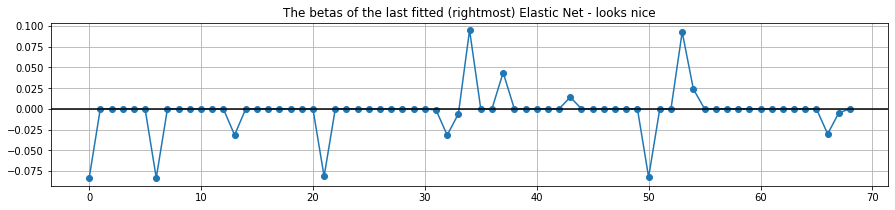

In [13]:
plot_coeffs(elastic, 'last fitted (rightmost) Elastic Net', 'looks nice')

In [14]:
elastic.alpha

0.015186859114545365

In [15]:
elastic.alpha * (len(y) / n_folds) * 2

25.0

In [16]:
elastic.l1_ratio

0.33

### **Cross-Validation**

### a form of **Model Selection**
* *Introduction to Statistical Learning* Ch. 5
* Systematically *tune* the modelling
* Main strategy is familiar: comparing alternatives in k-fold splits (i.e. test/train splits)
* [Wikipedia's take](https://en.wikipedia.org/wiki/Cross-validation_(statistics))
* [scikit-learn's account](https://scikit-learn.org/stable/modules/cross_validation.html)

Difficulties of cross-validation with K-fold splits:
1. Randomness in K-Fold 
1. What should K be set to? 
   * Easier on the CPU to use a small number. 
   * But if $K$ is small, then we tune $\alpha$ to an unrealistic case, 
        * where we tune with many fewer observations, than we have in reality.
   * A balanced choice might be $K=5$ or $K=10$ for example (see *Introduction to Statistical Learning* 5.1.4)

$K=len(y)$ is known as Leave-One-Out Cross-Validation (LOOCV) [and is tantamount to the Jackknife]

Since we are now handling the tuning parameters, we will need to add a further stratum to our dataset:
* until now, we had just 2: `train -> test`
* from now onwards, 3: `train -> validation -> test`

Yes, this switch in terminology can be [confusing](https://en.wikipedia.org/w/index.php?title=Training,_validation,_and_test_sets&section=5#Confusion_in_Terminology), [and (personally) sometimes puzzling](https://scikit-learn.org/stable/_images/grid_search_workflow.png)

Prepare validation and test data:

In [17]:
from sklearn.model_selection import train_test_split

We will put `poly_std_X_test` and `y_test` to one side until the end of our work:

In [18]:
(poly_std_X_train, 
 poly_std_X_test,
 y_train, 
 y_test) = train_test_split(poly_std_X, y, test_size=0.95)  # < proportion 0.5 of the data put aside for final testing

However, we will successively break `poly_std_X_train` and `y_train` using KFolds splits into:
* training data
* validation data

First we'll see what this means, using our existing code.

Lets program a simple grid search:

In [19]:
alphas = [0.001, 0.01, 0.1, 1, 10]    # going up in factors of ten
l1_ratios =  [0.1, 0.5, 0.9]          # one balanced split, and two unbalanced splits (each way)
k_folds = [10]

In [20]:
score_cube = np.empty((len(alphas), len(l1_ratios), len(k_folds)))

In [21]:
score_cube.shape

(5, 3, 1)

In [22]:
score_cube[:] = np.nan   # a numpy operation: set all its elements to nan

for i, a in enumerate(alphas):
    for j, l in enumerate(l1_ratios):
        logging.info(f"Trying alpha of {a} and l1_ratio of {l}")
        for k, f in enumerate(k_folds):
            elastic_for_grid = linear_model.ElasticNet(alpha=a / len(y_train) / 2, l1_ratio=l)
            scores = sbs_sklearn.train_n_test(poly_std_X_train, y_train, f, model=elastic_for_grid)
            score_cube[i, j, k] = np.mean(scores)

2020-04-26 14:27:25,081 INFO:Trying alpha of 0.001 and l1_ratio of 0.1
2020-04-26 14:27:25,084 INFO:Study 1/10: 925 train rows;  103 test rows
2020-04-26 14:27:25,864 INFO:Trying alpha of 0.001 and l1_ratio of 0.5
2020-04-26 14:27:25,866 INFO:Study 1/10: 925 train rows;  103 test rows
2020-04-26 14:27:26,667 INFO:Trying alpha of 0.001 and l1_ratio of 0.9
2020-04-26 14:27:26,670 INFO:Study 1/10: 925 train rows;  103 test rows
2020-04-26 14:27:27,506 INFO:Trying alpha of 0.01 and l1_ratio of 0.1
2020-04-26 14:27:27,509 INFO:Study 1/10: 925 train rows;  103 test rows
2020-04-26 14:27:28,323 INFO:Trying alpha of 0.01 and l1_ratio of 0.5
2020-04-26 14:27:28,326 INFO:Study 1/10: 925 train rows;  103 test rows
2020-04-26 14:27:29,208 INFO:Trying alpha of 0.01 and l1_ratio of 0.9
2020-04-26 14:27:29,211 INFO:Study 1/10: 925 train rows;  103 test rows
2020-04-26 14:27:30,061 INFO:Trying alpha of 0.1 and l1_ratio of 0.1
2020-04-26 14:27:30,062 INFO:Study 1/10: 925 train rows;  103 test rows
2020

Results are not terribly stable:

In [23]:
degradation = (score_cube - np.min(score_cube)).round(4) * 100

In [24]:
print("L1_ratios of ", " ".join(str(l) for l in l1_ratios))
for k, f in enumerate(k_folds):
    print(f"\n K-fold of ", f)
    for i, a in enumerate(alphas):
        print(f"\n alpha of {a}:")
        print(degradation[i, :, k])

L1_ratios of  0.1 0.5 0.9

 K-fold of  10

 alpha of 0.001:
[1.14 1.36 1.92]

 alpha of 0.01:
[1.63 2.11 1.99]

 alpha of 0.1:
[1.54 1.41 0.99]

 alpha of 1:
[1.29 1.11 0.7 ]

 alpha of 10:
[0.99 0.44 0.  ]


... not particularly conclusive, so lets let Scikit-learn take the strain:

### Applying Elastic Net Cross-Validation within Scikit-Learn

In [25]:
elasticCV = linear_model.ElasticNetCV(l1_ratio=[.1, .5, .75, .95])
n_folds = 25

2020-04-26 14:27:37,355 INFO:Study 1/25: 824 train rows;  19753 test rows
2020-04-26 14:28:43,190 INFO:Study 10/25: 823 train rows;  19754 test rows
2020-04-26 14:29:48,326 INFO:Study 19/25: 823 train rows;  19754 test rows


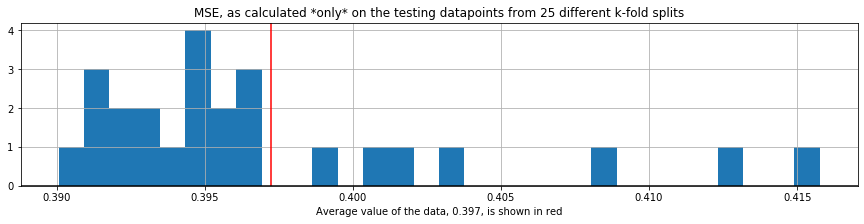

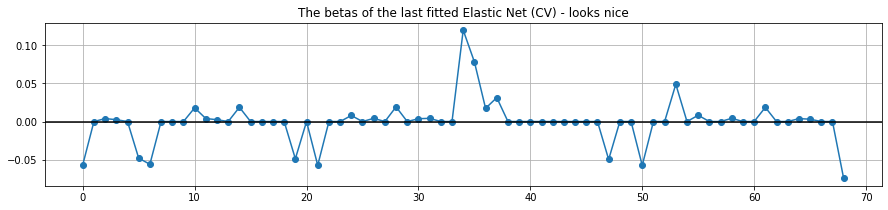

In [26]:
scores = sbs_sklearn.train_n_test(poly_std_X, y, n_folds, train_on_minority=True, model=elasticCV, update_frequency=9)
sbs_sklearn.plot_kfold_scores(scores)
plot_coeffs(elasticCV, 'last fitted Elastic Net (CV)', 'looks nice')

Let's do a LassoCV while we're about it:

2020-04-26 14:30:39,172 INFO:Study 1/25: 824 train rows;  19753 test rows
2020-04-26 14:30:47,809 INFO:Study 10/25: 823 train rows;  19754 test rows
2020-04-26 14:30:55,657 INFO:Study 19/25: 823 train rows;  19754 test rows


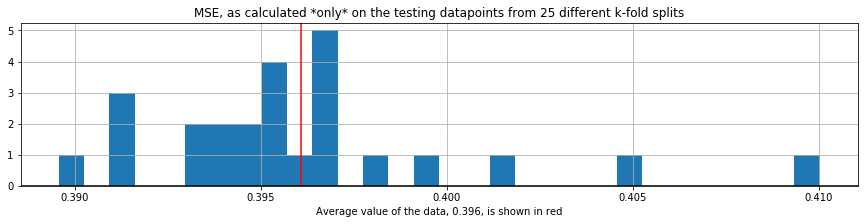

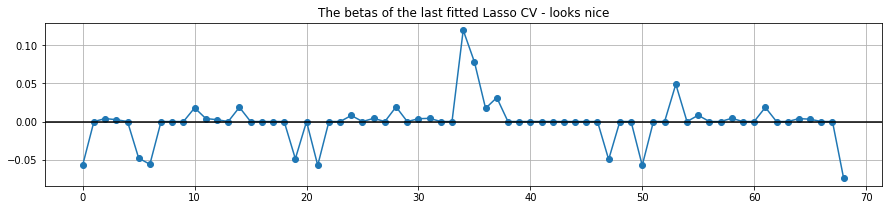

In [27]:
lassoCV = linear_model.LassoCV()
scores = sbs_sklearn.train_n_test(poly_std_X, y, n_folds, train_on_minority=True, model=lassoCV, update_frequency=9)
sbs_sklearn.plot_kfold_scores(scores)
plot_coeffs(elasticCV, 'last fitted Lasso CV', 'looks nice')

In [28]:
f"Cross Validation tunes alpha parameter to {lassoCV.alpha_ * (len(y) / n_folds) * 2 :.2f}, whereas JL had found 25 by guessing"

'Cross Validation tunes alpha parameter to 13.41, whereas JL had found 25 by guessing'

### The Bootstrap

*Introduction to Statistical Learning* 5.2

[Wikipedia](   https://en.wikipedia.org/wiki/Bootstrapping_(statistics)   ) 

### The Bootstrap: the problem setup

I have a large sample, $z$, consisting of $N$ observations that I can say are somewhat iid. I've developed an estimator, $S(Z)$, and the related estimate, $S(z)$.

  * so, $S(Z)$ is a random variable I've defined in order to measure a parameter of interest in the DGP, $\theta$
  
  * hopefully, its consistent, unbiased, even statistically efficient, however ...

If I want to do inference, I will need to understand its CDF, $F_S$.

To get at $F_S$, the approach from Michaelmas Term: asymptotic Central Limit Theory, e.g.
  
\begin{equation}
\sqrt{N}\left(S(Z) - \theta\right) \rightarrow^D N(0, \sigma^2)
\end{equation}

as $N \rightarrow \infty$. 

Now, however, we seek an alternative which exploits 
* improved computing power, and 
* larger sets of data.

### The Bootstrap is known for its **principle** and its **method**

Bootstrap principle:

* Replace the population distribution of the samples, with their empirical distribution (per our dataset)

* Derive $\tilde F_S$, by which we'll mean:
    1. the CDF of $S$ when there are $N$ observations, 
    1. under the distributional assumption in 1.


* Consider this to be a good approximation of $F_S$  [when there are $N$ observations].

Bootstrap method:

1. Where $i$ runs up through the integers from 0 to a big number:

     1. Randomly pick, *with replacement*, $N$ elements from $z$, assembling these to get $\tilde z_i$.

     1. Calculate and store $S(\tilde z_i)$

1. Study (plot) quantiles/distribution of the large set $\{S(\tilde z_1), S(\tilde z_2), S(\tilde z_3), ... \}$

1. Observe that this distribution approximates $\tilde F_S$

1. Therefore take this distribution to approximate $F_S$.

### We code up the bootstrap and try it out

(using `numpy`, including `numpy.random` - not many lines of code)

In [42]:
def bootstrap_resample(S):
    """
    @param S: a function that takes data and gives a statistic we want to know about
    @return: a new function that takes such data, and adds a smidge of randomness to get the bootstrap statistic
    """
    def func(Z):
        """
        @param Z: a numpy.array of data where the first dimension indexes the observations
        """
        Z_resampled = Z[np.random.randint(0, high=len(Z), size=len(Z))]
        return S(Z_resampled)
    return func

In [43]:
def show(statistic):
    return pd.DataFrame(statistic).round(1)

Think of a statistic, any statistic ...

In [44]:
def my_cov(z):
    """
    @return empirical covariance matrix
    """
    return np.dot(z.T, z) / len(z)

Here's the empirical covariance matrix of our familiar $X$:

In [45]:
x = X.values

In [46]:
X.columns

Index(['log_n_codes', 'hour', 'month', 'words_per_item'], dtype='object')

In [47]:
show(my_cov(x))

,0,1,2,3
0,8.0,32.4,5.099258e+05,7.2
1,32.4,167.3,2.554878e+06,39.3
2,509925.8,2554877.5,4.040070e+10,622405.9
3,7.2,39.3,6.224059e+05,10.3


... but how does this deviate from the true covariance matrix of $x_i$ (for any $i$)?

We begin by looking at an example of the bootstrap-resampled statistic:

In [48]:
br = bootstrap_resample(my_cov)(x)

In [49]:
show(br)

,0,1,2,3
0,8.0,32.4,5.105329e+05,7.1
1,32.4,166.6,2.549965e+06,39.1
2,510532.9,2549965.1,4.040075e+10,620986.9
3,7.1,39.1,6.209869e+05,10.2


... not that different to `my_cov(x)`

... but now lets make many (well, 1000) of these, 

each of them different because each is based on a different random sample of $X$:

In [50]:
bootstraps = [bootstrap_resample(my_cov)(x) for i in range(0, 1000)]

# this is a list of 2d arrays, which we can convert into a 3d numpy array:
bootstraps = np.array(bootstraps)

In [51]:
bootstraps.shape

(1000, 4, 4)

These have a highly suitable mean - we can think of this like a *consensus* of multiple estimators(/models) of that covariance:

In [52]:
show(np.mean(bootstraps, axis=0))

,0,1,2,3
0,8.0,32.4,5.099560e+05,7.2
1,32.4,167.3,2.554936e+06,39.3
2,509956.0,2554935.9,4.040071e+10,622395.1
3,7.2,39.3,6.223951e+05,10.3


Our theory tells us that: 

 * the standard deviations of the elements of `bootstraps` 
 * is an estimate 
 * of the standard deviation of the sample covariance matrix, itself.

OK, then lets take a look at these standard deviations:

In [53]:
show(np.std(bootstraps, axis=0))

,0,1,2,3
0,0.0,0.1,1774.7,0.0
1,0.1,0.4,3263.5,0.1
2,1774.7,3263.5,71841.9,1221.9
3,0.0,0.1,1221.9,0.0
